# analyzed single drifter processed (filtered, broken into sequence)

In [88]:
import os
from glob import glob
import pickle

from dask.distributed import Client
import dask.bag as db
import xarray as xr
import pandas as pd
import numpy as np
from scipy import signal
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr
import mitequinox.utils as eut

import pywt

data_dir = '/work/ALT/swot/aval/syn/drifters/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=12, walltime='12:00:00', memory='60GB')
#cluster = PBSCluster(cores=1, walltime='01:00:00', memory='20GB')
w = cluster.scale(12) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
client = Client(cluster)
#client = Client()

In [4]:
cluster

---

## load data

In [13]:
#files = sorted(glob(data_dir+'single/*.p'))
files = sorted(glob(data_dir+'single/gps_*.p'))
#files = files[:500]
print('%d single trajectories' %len(files))

b = ( db.from_sequence(files[:], npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )

3042 single trajectories


In [73]:
def process_track(p):
    ID = p[1]
    #dt = datetime.timedelta(T)
    _drop_col = ['GAP','RMSGAP']
    p0 = p[0].drop(columns=_drop_col, errors='ignore')
    tmin, tmax = p0.index[0], p0.index[-1]
    t=tmin
    # for position filtering
    p0 = edr.compute_vector(p0)
    # interpolate small gaps
    p0 = p0[~pd.isnull(p0.index)].resample('H').interpolate('linear', limit=24)
    return p0

In [95]:
df = process_track(b.take(5)[1])
df

,LAT,LON,LAT_ERR,LON_ERR,U,V,U_ERR,V_ERR,DROGUE,GPS,v0,v1,v2
TIME,,,,,,,,,,,,,
2012-11-04 18:00:00,24.43354,321.99774,62.0,68.0,-0.0055,-0.1247,0.0517,0.0517,1.0,1,0.717416,-0.560552,0.413637
2012-11-04 19:00:00,24.43089,321.99775,64.0,71.0,0.0062,-0.0495,0.0550,0.0550,1.0,1,0.717431,-0.560564,0.413595
2012-11-04 20:00:00,24.42955,321.99871,63.0,69.0,0.0380,-0.0312,0.0511,0.0511,1.0,1,0.717448,-0.560558,0.413574
2012-11-04 21:00:00,24.42855,321.99999,60.0,66.0,0.0444,-0.0313,0.0492,0.0492,1.0,1,0.717466,-0.560546,0.413558
2012-11-04 22:00:00,24.42729,322.00183,84.0,92.0,0.0643,-0.0407,0.0559,0.0559,1.0,1,0.717491,-0.560529,0.413538
2012-11-04 23:00:00,24.42600,322.00536,83.0,91.0,0.1005,-0.0408,0.0368,0.0368,1.0,1,0.717533,-0.560490,0.413518
2012-11-05 00:00:00,24.42487,322.00914,94.0,103.0,0.1132,-0.0374,0.0526,0.0526,1.0,1,0.717577,-0.560448,0.413500
2012-11-05 01:00:00,24.42399,322.01288,90.0,99.0,0.1164,-0.0220,0.0478,0.0478,1.0,1,0.717618,-0.560405,0.413486
2012-11-05 02:00:00,24.42331,322.01689,61.0,67.0,0.1265,-0.0166,0.0338,0.0338,1.0,1,0.717661,-0.560358,0.413475


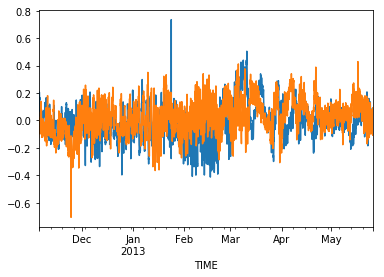

In [96]:
df['U'].plot()
df['V'].plot()

In [54]:
#wavlist = pywt.wavelist(kind='continuous')
#wavlist

In [106]:
scales = np.arange(4.,2*24,.1)
dt = 1/24.  # 1h 
U_cwt, omega = pywt.cwt(df['U'], scales, 'cmor1.5-1.0', sampling_period=dt)
f = eut.coriolis(df['LAT'])*86400./2./np.pi

In [107]:
#frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
#frequencies

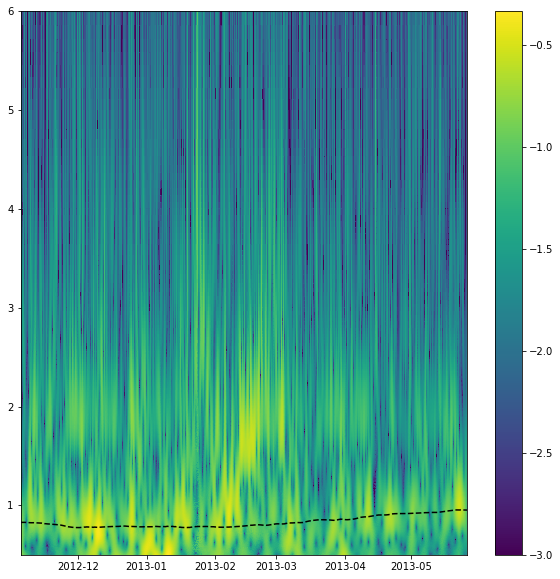

In [110]:

fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1)

im = ax.pcolormesh(df.index, omega, np.log10(np.abs(U_cwt)), vmin=-3.)
#ax.add_colorbar()
fig.colorbar(im)
ax.plot(df.index,f,'k--')

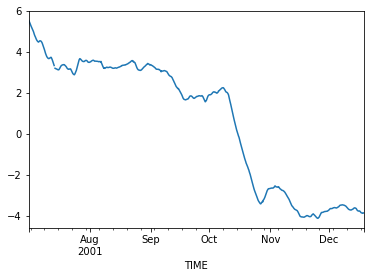

In [94]:
df.LAT.plot()

In [16]:
ds = xr.open_mfdataset(data_dir+'single_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True)

In [15]:
#client.restart()

In [17]:
ds = ds.persist()

In [18]:
ds = ds.chunk({'index': 1000}).persist()

In [37]:
#ds = ds.drop('pair') # try to see if this breaks stacking further below
#ds = ds.chunk({'index': 1e4})
#ds.to_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr', mode='w')

---

In [19]:
#ds = ds.persist()
ds.to_zarr(data_dir+'single_tfilt/filtered_sequences.zarr', mode='w')
#ds = xr.open_zarr(data_dir+'single_tfilt/filtered_sequences.zarr')

In [21]:
print('Dataset size = %.1f GB '%(ds.nbytes/1e9))
ds

Dataset size = 2.4 GB 


<xarray.Dataset>
Dimensions:           (TIME: 721, index: 11327)
Coordinates:
  * TIME              (TIME) timedelta64[ns] 00:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LON               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    U                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    V                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LAT_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    LON_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    U_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    V_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(1000, 721)>
    DROGU

---

In [40]:
ndrop = ['v%d'%d for d in range(3)]
ndrop += ['U','V','LON','LAT']
ndrop += [v+'_low' for v in ['U','V']]
ndrop += [v+'_inertial' for v in ['U','V']]
ndrop += ['ID']

#ds = drop(ds,ndrop)

In [22]:
#ds = ds.persist()

---
## derives basic statistics: 

- averaged distance travelled over time block

- averaged location distribution

In [23]:
start = ds.isel(TIME=0)
end = ds.isel(TIME=-1)
d_travelled = (edr.haversine(start.LON, start.LAT, 
                             end.LON, end.LAT)
                      .rename('d_travelled').persist())

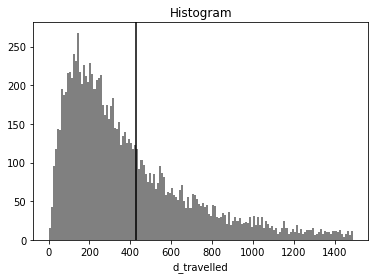

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
_, _, _ = d_travelled.plot.hist(ax=ax, bins=np.arange(0.,1.5e3,10.), color='0.5')
ax.axvline(x=d_travelled.mean(),color='k')

---

## spectra

In [26]:
ds.TIME.size

721

In [40]:
def _get_E(x, ufunc=True, **kwargs):
    #ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.periodogram(x, fs=24., axis=-1, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        Nb = v.TIME.size
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['TIME']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [41]:
f, Eu = get_E(ds.U.isel(index=0))

In [42]:
Eu = get_E(ds.U.fillna(0.), f)

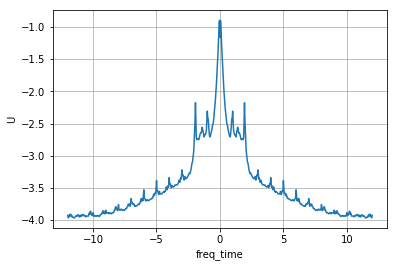

In [45]:
fig, ax = plt.subplots(1,1)
np.log10(Eu.mean('index')).plot(ax=ax)
ax.grid()

In [53]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5

#ds['LAT_mean'] = (ds.LAT.mean('TIME')+0.*ds.LAT).rename('LAT_mean')
ds['LAT_mean'] = ds.LAT.mean('TIME')
Eu_zav = Eu.groupby_bins(ds.LAT_mean, bins=latb).mean(dim=['index'])

<xarray.DataArray 'U' (LAT_mean_bins: 139, freq_time: 721)>
dask.array<shape=(139, 721), dtype=float64, chunksize=(1, 721)>
Coordinates:
  * LAT_mean_bins  (LAT_mean_bins) object (-70.0, -69.0] ... (68.0, 69.0]
  * freq_time      (freq_time) float64 -11.98 -11.95 -11.92 ... 11.95 11.98

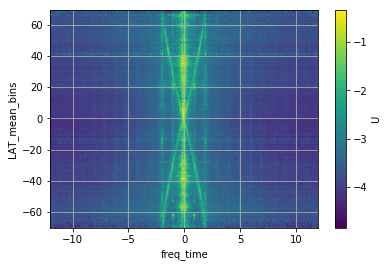

In [55]:
fig, ax = plt.subplots(1,1)
np.log10(Eu_zav).plot(ax=ax,x='freq_time',y='LAT_mean_bins')
ax.grid()

In [21]:
rb = np.arange(0.,300.,10.)
rc = (rb[:-1]+rb[1:])*.5

In [22]:
ds['r'] = ds.r.where(~np.isnan(ds.U_0_inertial*ds.U_0_low), drop=False)
#mask = xr.where(np.isnan(ds.LON_0_inertial*ds.LON_0_low), 0, 1)
#ds.r = ds.r*mask

In [23]:
N_r = edr.bin1d(ds.r, ds.r, rb, False, bin_dim='rb', name='N_r')
N_r = N_r.sum('index')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [24]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5
lonb = np.arange(-180.,180.,1.)
lonc = (lonb[:-1]+lonb[1:])*.5

In [25]:
ll = edr.bin2d(ds.r, ds.LON_0, lonb, ds.LAT_0, latb, False, bin_dim1='lonb', bin_dim2='latb', name='Ncount')
ll = ll.sum('index')

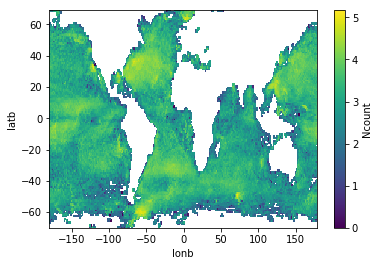

In [26]:
np.log10(ll).plot(x='lonb', y='latb')

---

## plot selected trajectories

In [27]:
lds = ds.isel(index=slice(0,2000)).persist()

In [28]:
rmean = lds.r.mean('TIME').persist()
#U02_inertial_mean = (lds.U_0_inertial**2).mean('TIME').persist()
U_inertial = np.abs(lds.U_0_inertial).mean('TIME').persist()

In [29]:
#lds = lds.where( (rmean<105) & (rmean>95) , drop=True)
lds = lds.where( U_inertial>.1 , drop=True)
lds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 99)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    U_0           (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    V_0           (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v0_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v1_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    v2_0          (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 721)>
    LON_1         (index, TIME) float64 dask.array<shape=(99, 721), chunksize=(25, 

In [30]:
#del lds

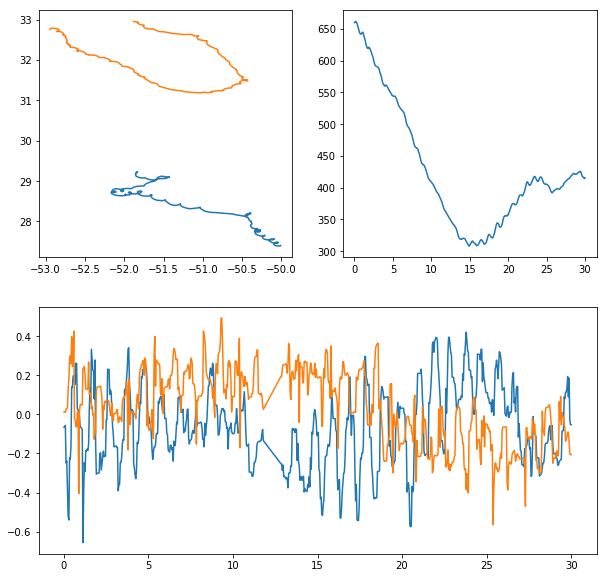

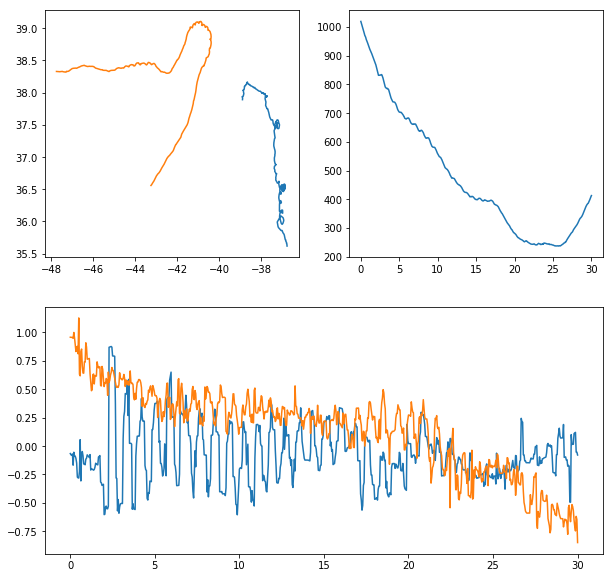

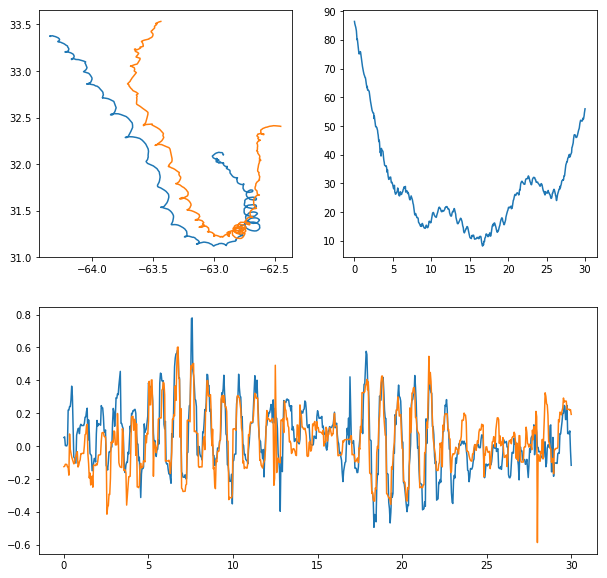

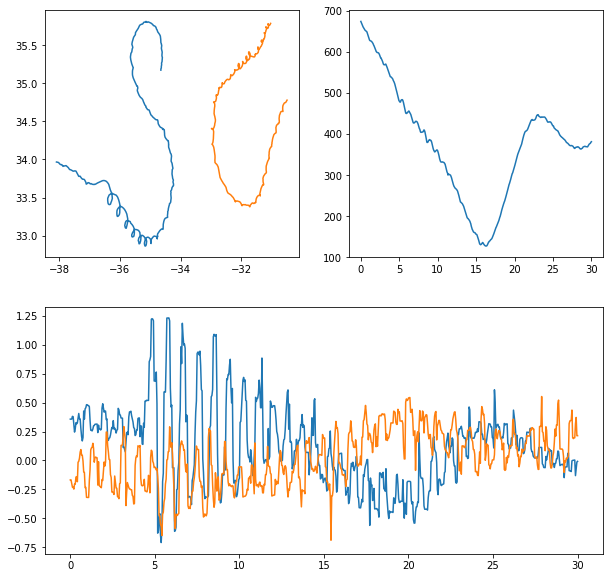

In [34]:
def plot_trajectories(ds):
    t = ds.TIME/np.timedelta64(1, 'D')
    for i in ds.index:
        lds = ds.sel(index=i)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(221)
        ax.plot(lds.LON_0, lds.LAT_0, label='0')
        ax.plot(lds.LON_1, lds.LAT_1, label='1')
        ax = fig.add_subplot(212)
        ax.plot(t,lds.U_0, label='0')
        ax.plot(t,lds.U_1, label='1')
        ax = fig.add_subplot(222)
        ax.plot(t,lds.r,label='r')
        #print(lds.lon_1.values)
        
plot_trajectories(lds.isel(index=slice(0,4)))

---
## computations of decorrelation length scales for velocity

In [35]:
def get_UV_prod(N_r, band=''):
    ods = N_r.to_dataset()
    if band != '':
        suff = '_'+band
    else:
        suff = band
    #
    for u0 in ['U', 'V']:
        for u1 in ['U', 'V']:
            ods[u0+'0'+u1+'1'+suff] = (edr.bin1d(ds[u0+'_0'+suff]*ds[u1+'_1'+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                                  .sum('index')/ods.N_r)
    for i in ['0','1']:
        for u in ['U','V']:
            ods[u+i+u+i+suff] = (edr.bin1d(ds[u+'_'+i+suff]*ds[u+'_'+i+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                            .sum('index')/ods.N_r)
    return ods

In [36]:
ds_inst = get_UV_prod(N_r)
ds_low = get_UV_prod(N_r, 'low')
ds_inertial = get_UV_prod(N_r, 'inertial')
ods = xr.merge([ds_inst, ds_low, ds_inertial]).persist()

In [37]:
ods

<xarray.Dataset>
Dimensions:        (rb: 29)
Coordinates:
  * rb             (rb) float64 5.0 15.0 25.0 35.0 ... 255.0 265.0 275.0 285.0
Data variables:
    N_r            (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U0           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0V0           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U1U1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V1V1           (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U1_low       (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0V1_low       (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    V0U1_low       (rb) float64 dask.array<s

In [38]:
def plot_band(band):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(131)

    U0U0, V0V0 = ods['U0U0'+band], ods['V0V0'+band]
    U1U1, V1V1 = ods['U1U1'+band], ods['V1V1'+band]
    U0U1, V0V1 = ods['U0U1'+band], ods['V0V1'+band]

    (U0U1/np.sqrt(U0U0*U1U1)).plot(ax=ax, label='U0U1 normalized')
    (V0V1/np.sqrt(V0V0*V1V1)).plot(ax=ax, label='V0V1 normalized')
    ax.legend()
    ax.set_ylim(0.,1.)

    ax = fig.add_subplot(132)
    np.sqrt(U0U0).plot(ax=ax, label='U0U0')
    np.sqrt(V0V0).plot(ax=ax, label='V0V0')
    np.sqrt(U1U1).plot(ax=ax, color='C0', ls='--')
    np.sqrt(V1V1).plot(ax=ax, color='C1', ls='--')
    ax.legend()
    ax = fig.add_subplot(133)
    ods.N_r.plot(ax=ax)

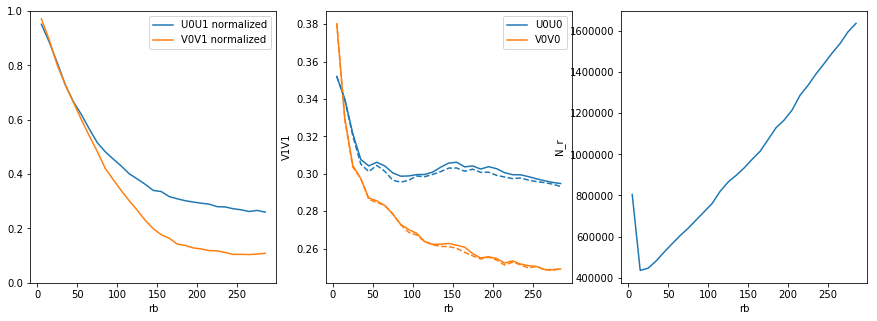

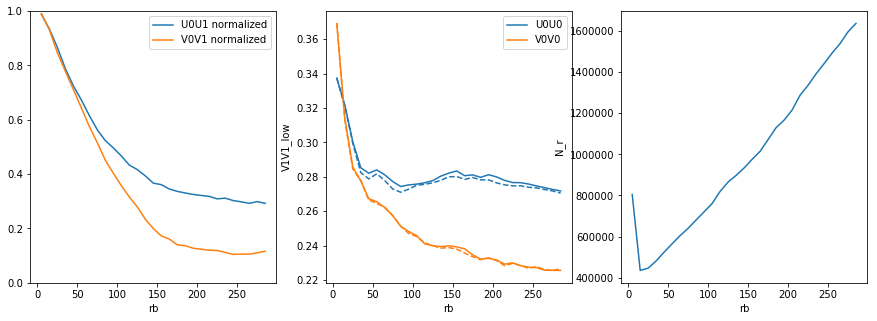

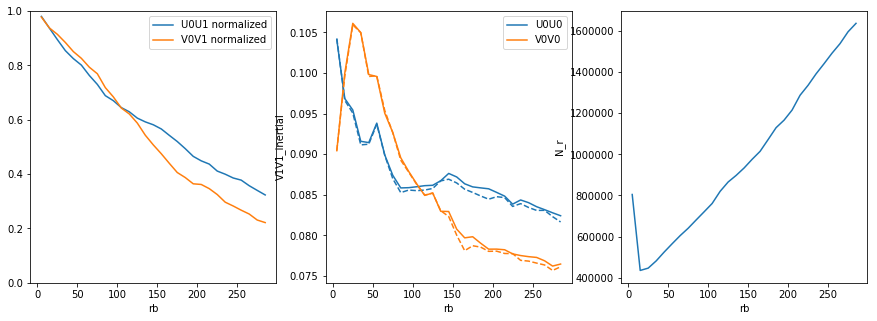

In [39]:
for band in ['','_low','_inertial']:
    plot_band(band)

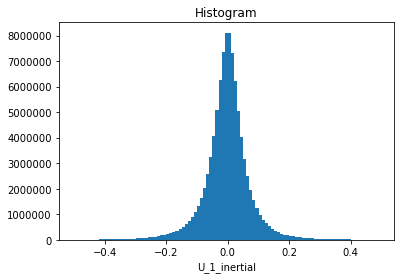

In [40]:
_ = ds['U_1_inertial'].plot.hist(bins=np.arange(-.5,.5,.01))

---

In [34]:
client.restart()

Worker tcp://10.135.36.35:37710 restart in Job 5261702. This can be due to memory issue.
Worker tcp://10.135.36.32:43072 restart in Job 5261700. This can be due to memory issue.
Worker tcp://10.135.36.39:38365 restart in Job 5261703. This can be due to memory issue.
Worker tcp://10.135.36.35:36440 restart in Job 5261702. This can be due to memory issue.
Worker tcp://10.135.36.40:35096 restart in Job 5261707. This can be due to memory issue.
Worker tcp://10.135.36.40:40446 restart in Job 5261708. This can be due to memory issue.
Worker tcp://10.135.36.39:40935 restart in Job 5261705. This can be due to memory issue.
Worker tcp://10.135.36.39:43364 restart in Job 5261706. This can be due to memory issue.
Worker tcp://10.135.36.39:34064 restart in Job 5261703. This can be due to memory issue.
Worker tcp://10.135.36.39:44824 restart in Job 5261704. This can be due to memory issue.
Worker tcp://10.135.36.32:37505 restart in Job 5261700. This can be due to memory issue.
Worker tcp://10.135.3

Client Scheduler: tcp://10.135.39.56:48612 Dashboard: http://10.135.39.56:8787/status,Cluster Workers: 10 Cores: 60 Memory: 200.00 GB


In [ ]:
cluster.close()